In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import glob

# from scipy import signal
# import math
# import collections

import sys
sys.path.append('../scripts')
import util
import ip_routines as ip

verbose = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
image_folder_lst = ['../projects/contact_front/MR_NewCam']
img_lst = util.Image_List(image_folder_lst, '2015-08-04_DFI28-*.png', doSort=True, color=True)

print "Read %d images from %s" % (img_lst.cnt(), image_folder_lst[0])

Read 20 images from ../projects/contact_front/MR_NewCam


In [41]:
def calulateDeltaRatio(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    delta_img = ip.deltaImage(bg_img, fg_img, 5)
    #blue_chan_mean = np.abs(np.mean(blue_chan))
    hist = np.bincount(delta_img.ravel(),minlength=256)
    ratio = float(hist[-1])/float(hist[0])
    return hist[0], hist[1], ratio

In [42]:
def processImages_CumSumDiff(eng, delay_s, do_plot, verbose):
    stats = {}
    stats['areas'] = []
    stats['deltas'] = []
    
    ret, bg_img = eng.next()
    if not ret:
        return ret, stats

    cum_img = np.zeros(bg_img.shape[:2], np.bool)
    total_size = cum_img.size

    ret, fg_img = eng.next()
    while ret:
        delta_img = ip.deltaImage(bg_img, fg_img, thresh_val=5)
        delta_img_blurred = cv2.GaussianBlur(delta_img, (55, 55), 0)

        before_cnt = np.count_nonzero(cum_img)
        cum_img = np.logical_or(cum_img, delta_img_blurred)
        after_cnt = np.count_nonzero(cum_img)

        area  = total_size - after_cnt
        delta = after_cnt - before_cnt
        stats['areas'].append(area)
        stats['deltas'].append(delta)
        print("[%d] Area: %d, Delta: %d" % (eng.idx(), area, delta))

        bg_img = fg_img
        ret, fg_img = eng.next()
    return True, stats

Image Engine initialized with  ../projects/contact_front/MR_NewCam/startAtFirstCircle/2015-08-04_DFI28-*.png
 Total images:  426
[2] Area: 862848, Delta: 391328
[3] Area: 844023, Delta: 18825
[4] Area: 834297, Delta: 9726
[5] Area: 794707, Delta: 39590
[6] Area: 781010, Delta: 13697
[7] Area: 772463, Delta: 8547
[8] Area: 744445, Delta: 28018
[9] Area: 734864, Delta: 9581
[10] Area: 728268, Delta: 6596
[11] Area: 719089, Delta: 9179
[12] Area: 714477, Delta: 4612
[13] Area: 711182, Delta: 3295
[14] Area: 690274, Delta: 20908
[15] Area: 685047, Delta: 5227
[16] Area: 672326, Delta: 12721
[17] Area: 651070, Delta: 21256
[18] Area: 635696, Delta: 15374
[19] Area: 628207, Delta: 7489
[20] Area: 624857, Delta: 3350
[21] Area: 613233, Delta: 11624
[22] Area: 605788, Delta: 7445
[23] Area: 601270, Delta: 4518
[24] Area: 596865, Delta: 4405
[25] Area: 595032, Delta: 1833
[26] Area: 592473, Delta: 2559
[27] Area: 580382, Delta: 12091
[28] Area: 578660, Delta: 1722
[29] Area: 558637, Delta: 2002

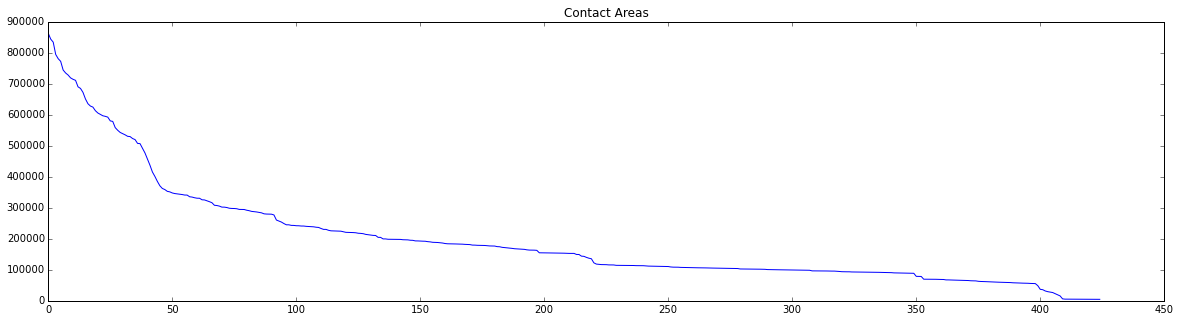

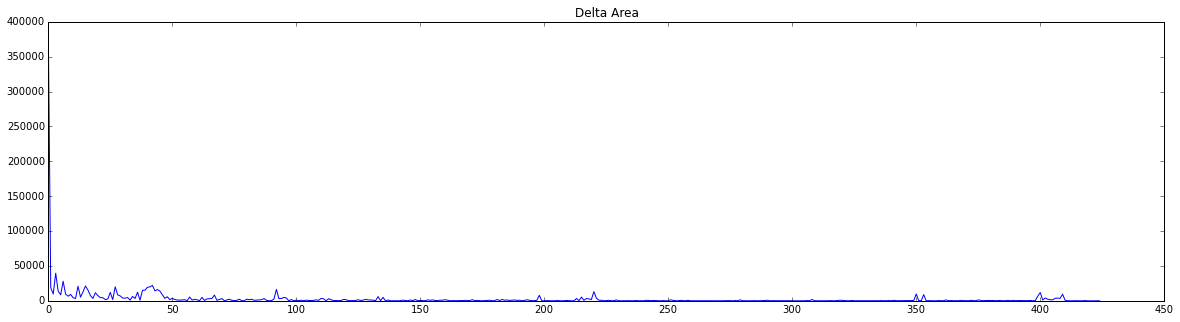

In [45]:
#image_folder_lst = ['../projects/contact_front/MR_NewCam']
image_folder_lst = ['../projects/contact_front/MR_NewCam/startAtFirstCircle']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/transitionSet']
#image_folder_lst = ['../projects/contact_front/MR_NewCam/testSet']

file_spec = '2015-08-04_DFI28-*.png'
glob_spec = "%s/%s" % (image_folder_lst[0], file_spec)
eng = util.Image_Engine(glob_spec, is_glob=True)

delay_s=0.01
do_plot=False  # must be False for running in notebook
verbose=True

ret, stats = ip.processImages_CumSumDiff(eng, delay_s, do_plot, verbose)

if len(stats['areas']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot(stats['areas'])
    plt.title('Contact Areas')
    
if len(stats['deltas']) > 0:
    plt.figure(figsize=(10*2,5))
    plt.plot(stats['deltas'])
    plt.title('Delta Area')


Count non-zero before:  0
Count non-zero after :  50204
Count non-zero before:  50204
Count non-zero after :  380879


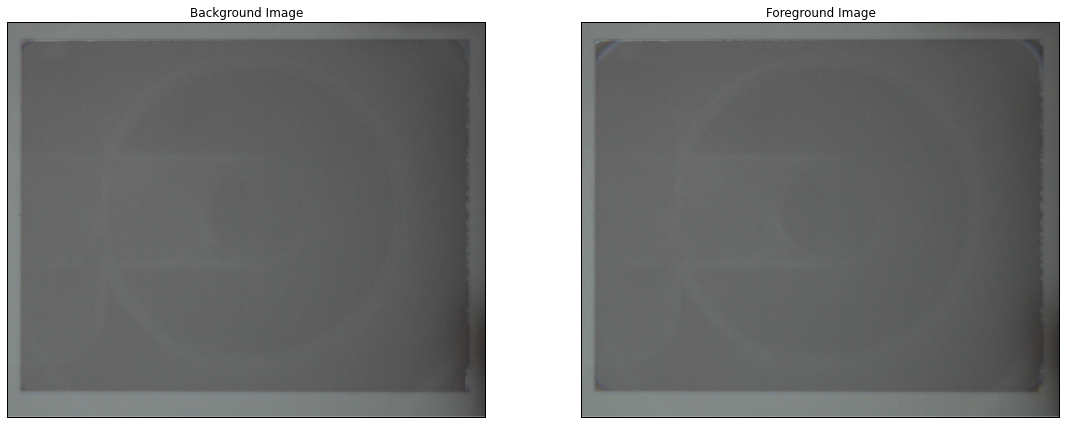

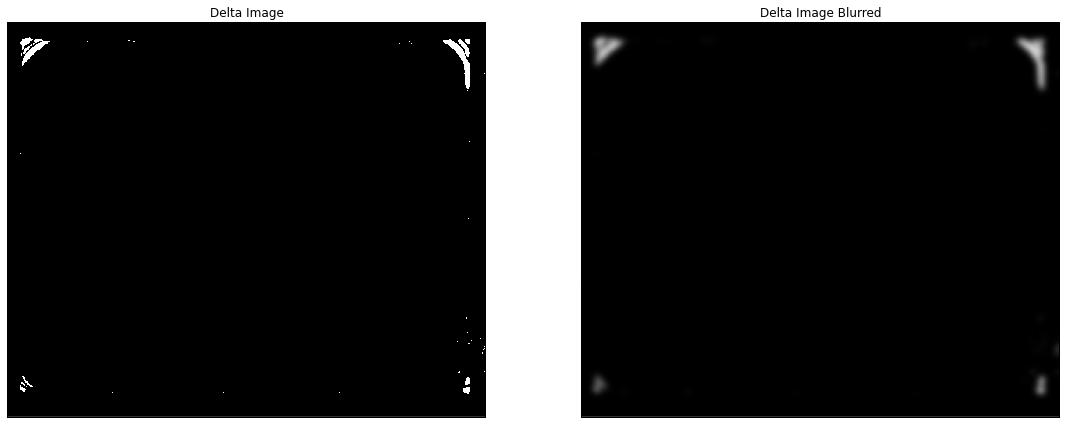

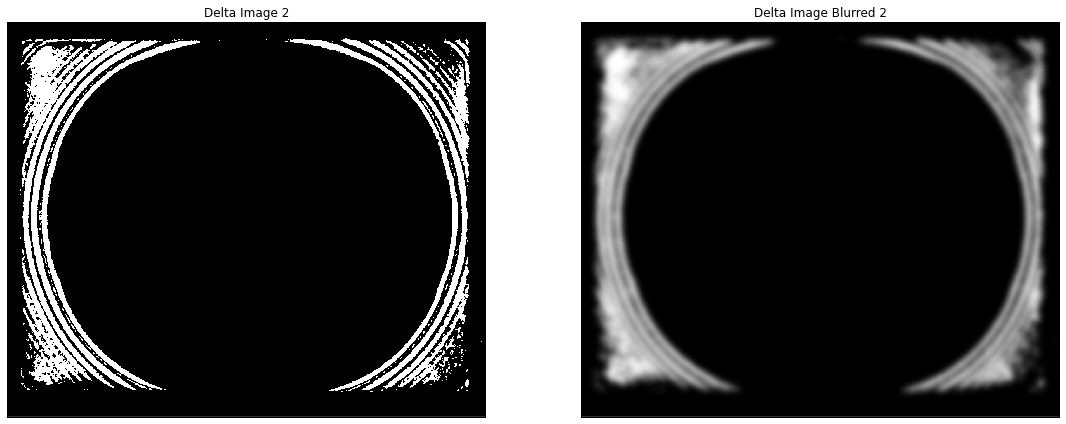

In [44]:
plot_lst = []
fg_num = 1
bg_img = img_lst.images[fg_num-1].copy()
fg_img = img_lst.images[fg_num].copy()

plot_lst.append( (bg_img, 'Background Image'))
plot_lst.append( (fg_img, 'Foreground Image'))

cum_img = np.zeros(fg_img.shape[:2], np.bool)

#delta_img = cv2.absdiff(bg_img, fg_img)
delta_img = ip.deltaImage(bg_img, fg_img, thresh_val=5)
plot_lst.append( (delta_img, 'Delta Image'))

delta_img_blurred = cv2.GaussianBlur(delta_img, (55, 55), 0)
plot_lst.append( (delta_img_blurred, 'Delta Image Blurred'))

print "Count non-zero before: ", np.count_nonzero(cum_img)
cum_img = np.logical_or(cum_img, delta_img_blurred)
print "Count non-zero after : ", np.count_nonzero(cum_img)

bg_img = fg_img
fg_img = img_lst.images[fg_num+1].copy()

delta_img = ip.deltaImage(bg_img, fg_img, thresh_val=5)
plot_lst.append( (delta_img, 'Delta Image 2'))

delta_img_blurred = cv2.GaussianBlur(delta_img, (55, 55), 0)
plot_lst.append( (delta_img_blurred, 'Delta Image Blurred 2'))

print "Count non-zero before: ", np.count_nonzero(cum_img)
cum_img = np.logical_or(cum_img, delta_img_blurred)
print "Count non-zero after : ", np.count_nonzero(cum_img)

util.plot_imgs(plot_lst, color=False, max_cols = 2)

blacks: 1248310, whites: 0, ratio: 0.00470


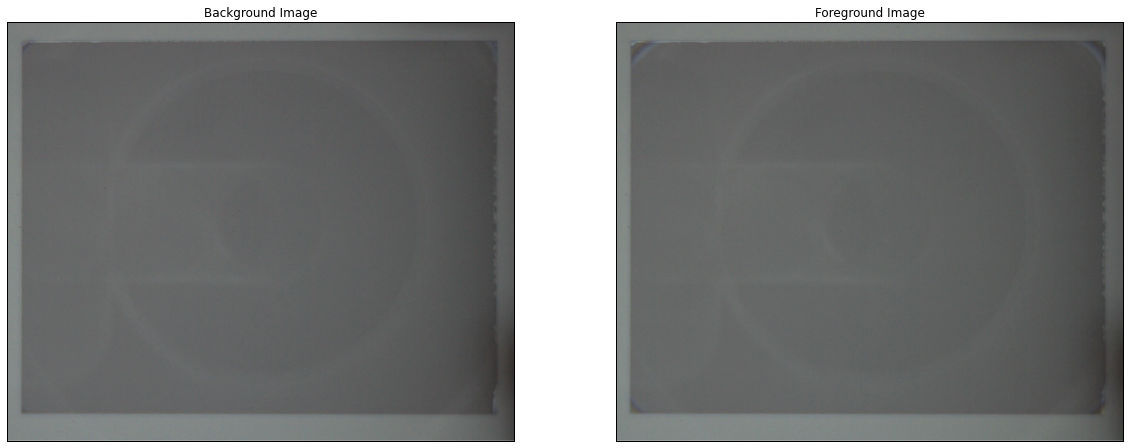

In [23]:
plot_lst = []
fg_num = 1
bg_img = eng.images[fg_num-1].copy()
fg_img = eng.images[fg_num].copy()

plot_lst.append( (bg_img, 'Background Image'))
plot_lst.append( (fg_img, 'Foreground Image'))

# hist = np.bincount(delta_img.ravel(),minlength=256)
# plt.plot(hist)

# blacks = hist[0]
# whites = hist[-1]
# ratio = float(whites)/float(blacks)

blacks, whites, ratio = calulateDeltaRatio(bg_img, fg_img)
print ("blacks: %d, whites: %d, ratio: %.5f" % (blacks, whites, ratio))

util.plot_imgs(plot_lst, color=False, max_cols = 2)

In [ ]:
video_file_path = '/data/projects/contact_front/MR_NewCam/2015-08-04_DFI28.mp4'

cap = cv2.VideoCapture(video_file_path)

cnt = 0
prev_img = None

ratios = []
while(cap.isOpened()):
    ret, new_img = cap.read()
    cnt += 1
    
    if ret:
        if prev_img == None:
            prev_img = new_img
            continue

        blacks, whites, ratio = calulateDeltaRatio(prev_img, new_img)
        ratios.append(ratio)

print "Done processing ", cnt, " images..."
print "Found ", len(ratios), " data pts:"
plt.figure(figsize=(10*2,5))
plt.plot(ratios, color='b')
plt.title('RGB mean values from center ROI')

### 